# Powerline discretization

Figure 7 of the Kang et al. (2020) is generated using this notebook. 

In [1]:
from SimPEG import Mesh, Utils
import numpy as np
from simpegEM1D import diffusion_distance
from pymatsolver import Pardiso
from SimPEG import EM
from scipy.constants import mu_0
from scipy.interpolate import interp1d
from simpegEM1D.Waveforms import piecewise_pulse_fast
from pyMKL import mkl_set_num_threads
from simpegskytem.TDEM import ProblemSkyTEM
from mesh_utils import refineTree, meshBuilder
num_threads = 4
mkl_set_num_threads(num_threads)

tmin, tmax = 1e-6, 1e-2
sigma_for_padding = 1./100.
padding_distance = np.round(diffusion_distance(1e-2, sigma_for_padding) * 2)
sigma_halfspace = 1./20.
layer_thickness = 4
resistivity_near = 100.


x = np.linspace(-250, 250)
y = np.linspace(-250, 250)
z = np.array([0.])
dem = Utils.ndgrid(x,y,z)


result_dir = "./n_tower/"

maxLevel = 11
h = [1, 1, 1]
octreeLevel = [0, 1, 1, 1, 4, 4, 10]
# n_towers = [2, 4, 6, 8, 10, 12, 14]
ground_resistance = 20.
n_tower = 2
padDist = np.ones((3, 2)) * padding_distance
mesh = meshBuilder(
    dem, h, padDist, 
    meshType='TREE',
    verticalAlignment='center'
)
# Refine the mesh around topographyttb
mesh = refineTree(
    mesh, dem, 
    dtype='surface', 
    octreeLevels=octreeLevel, 
    finalize=False
)

y = np.linspace(-40, 40)
x = np.linspace(-10, 10)
z = np.array([0.])
tmp = Utils.ndgrid(x,y,z)

# Refine the mesh around topography
mesh = refineTree(mesh, tmp, dtype='surface',
                                   octreeLevels=[0, 0, 0, 0, 0, 1], finalize=False)
n_segment = int(n_tower)
l_copper = 80.
ys = np.arange(n_segment) * l_copper
shift = -ys.max()/2.
ys += shift

x1 = 0.
# z1, z2 = -h[0]*2., 10.
z1, z2 = -3., 10.
# z1, z2 = 0., 10.
ys_corr = []
for y_temp in ys:
    ys_corr.append(mesh.vectorNy[np.argmin(abs(mesh.vectorNy-y_temp))])

ys = np.hstack(ys_corr)
x1 = mesh.vectorNx[np.argmin(abs(mesh.vectorNx-x1))]
z1 = mesh.vectorNz[np.argmin(abs(mesh.vectorNz-z1))]
z2 = mesh.vectorNz[np.argmin(abs(mesh.vectorNz-z2))]

pts_top = []
pts_bottom = []
for ii in range(n_segment-1):
    ind_y_top = np.logical_and(mesh.vectorNy>=ys[ii], mesh.vectorNy<=ys[ii+1])
    ex = np.ones(ind_y_top.sum()) * x1
    ez = np.ones(ind_y_top.sum()) * z2
    pts_top.append(np.c_[ex, mesh.vectorNy[ind_y_top], ez])
    ez = np.ones(ind_y_top.sum()) * z1
    pts_bottom.append(np.c_[ex, mesh.vectorNy[ind_y_top], ez])

pts_tower = []
for ii in range(n_segment):
    ind_z_side = np.logical_and(mesh.vectorNz>=z1, mesh.vectorNz<=z2)
    ex = np.ones(ind_z_side.sum())*x1
    ey = np.ones(ind_z_side.sum())*ys[ii]
    pts_tower.append(np.c_[ex, ey, mesh.vectorNz[ind_z_side]])

# pts = np.vstack((np.vstack(pts_top), np.vstack(pts_bottom), np.vstack(pts_tower)))
pts = np.vstack((np.vstack(pts_top), np.vstack(pts_tower)))
mesh = refineTree(mesh, pts, dtype='point', octreeLevels=[1, 0, 0], finalize=False)

survey_length = 400.
dx = 4
n_src = survey_length / dx
x = np.arange(n_src) * dx
x -= x.max()/2.

y = np.array([abs(mesh.vectorCCy).min()])
z_src = 40.
z = np.array([z_src])

xyz = Utils.ndgrid(x, y, z)
mesh = refineTree(mesh, xyz, dtype='point',
                                   octreeLevels=[1, 0, 0], finalize=True, maxLevel=maxLevel)

In [2]:
sigma = np.ones(mesh.nC) * 1./20
inds_air = mesh.gridCC[:, 2] > 0.
sigma[mesh.gridCC[:, 2] > 0.] = 1e-8

indArr, levels = mesh.__getstate__()
inds = levels == levels.max()

temp = np.unique(levels)
cell_size = 2**(temp.max()-temp)
print (n_tower)

radius_copper = 3.264 * 1e-3/2.
area_copper = np.pi * radius_copper **2
radius_rod = 15.87 * 1e-3 / 2.
area_rod = np.pi * radius_rod **2
sigma_copper = 6e7
sigma_rod = 1e8
area = (mesh.hx.min() * 4)**2
sigma[np.logical_and(inds, inds_air)] = sigma_copper * area_copper / area
inds_layer_near = (
    (np.logical_and(mesh.gridCC[:,2]<0., mesh.gridCC[:,2]>-layer_thickness)) & 
    (np.logical_and(mesh.gridCC[:,0]>-4, mesh.gridCC[:,0]<4)) &
    (np.logical_and(mesh.gridCC[:,1]>-43, mesh.gridCC[:,1]<43))
)

sigma[inds_layer_near] = 1./resistivity_near
inds_layer = np.logical_and(mesh.gridCC[:,2]<0., mesh.gridCC[:,2]>-3)
sigma[np.logical_and(inds, ~inds_air) & (inds_layer)] = sigma_rod * area_rod / area

2


In [3]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable

import matplotlib
matplotlib.rcParams['font.size'] = 14

In [4]:
import matplotlib as mpl
from pylab import cm
def discrete_cmap(N=4):    
    """create a colormap with N (N<15) discrete colors and register it"""
    # define individual colors as hex values
#     cpool = ['#00FFFF', '#3CB371','#DAA520','#DC143C','#8A2BE2']
#     cpool = ['white','green', 'orange', 'skyblue', 'red']
    cpool = ['orange','green', 'skyblue', 'red', 'white']    
    cmap3 = mpl.colors.ListedColormap(cpool[0:N], 'indexed')
    cm.register_cmap(cmap=cmap3)
    return cmap3
geomap = discrete_cmap(N=5)    

ind_0 = sigma == np.unique(sigma)[0]
ind_1 = sigma == np.unique(sigma)[1]
ind_2 = sigma == np.unique(sigma)[2]
ind_3 = sigma == np.unique(sigma)[3]
ind_4 = sigma == np.unique(sigma)[4]


pw_model = np.zeros_like(sigma)
pw_model[ind_0] = 4
pw_model[ind_1] = 1
pw_model[ind_2] = 0
pw_model[ind_3] = 3
pw_model[ind_4] = 2

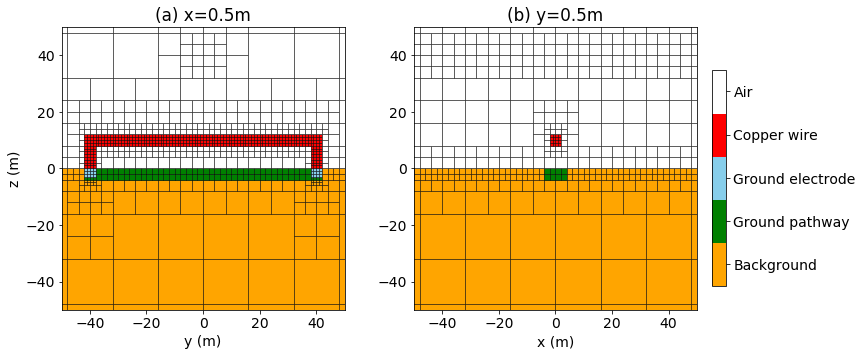

In [5]:
# sigma[mesh.gridCC[:,2]>0.] = np.nan
fig, axs = plt.subplots(1,2, figsize=(10, 5))
clim = -0.5, 4.5
out = mesh.plotSlice(
    pw_model, grid=True, normal='X', pcolorOpts={'cmap':geomap}, ax=axs[0], 
    clim=clim
)
axs[0].set_xlim(-50, 50)
axs[0].set_ylim(-50, 50)
axs[0].set_aspect(1)
axs[0].set_xlabel('y (m)')
axs[0].set_ylabel('z (m)')
axs[0].set_title(('(a) x=0.5m'))
# axs[0].plot(xyz[:,1], xyz[:,2], 'k.')

out = mesh.plotSlice(
    pw_model, grid=True, normal='Y', pcolorOpts={'cmap':geomap}, ax=axs[1], 
    clim=clim
)
axs[1].set_xlim(-50, 50)
axs[1].set_ylim(-50, 50)
axs[1].set_aspect(1)
axs[1].set_xlabel('x (m)')
axs[1].set_ylabel(' ')
axs[1].set_title(('(b) y=0.5m'))
# axs[1].plot(xyz[:,0], xyz[:,2], 'k.')

cbaxes = fig.add_axes([1, 0.2, 0.02, 0.6]) 
cb = plt.colorbar(
    out[0], cax=cbaxes, orientation='vertical', 
    ticks=[0, 1, 2, 3, 4], 
)
# cb.set_ticklabels(["Air", "Near-surface", "Background", "Ground electrode", "Copper wire"])
cb.set_ticklabels(["Background", "Ground pathway", "Ground electrode", "Copper wire", "Air"])
plt.tight_layout()
fig.savefig("./figures/figure-7", dpi=200)

In [6]:
# mesh.writeUBC('mesh.msh', models={'sigma.con':sigma})